# Report Analysis
Save figures where possible using ```plt.savefig('image.png')```

Image ideas:
* Accuracy vs Partition number : performance 
* Runtime vs Partition number : speed
* Accuracy vs Runtime : trade-off
* Speed-up : scalability against serial implementation
* Confusion Matrices 
* (potentially Size-up / Scale-up)

Ensure the evaluation metrics identified in lit review reflect this. 

In [39]:
import os
import json
import pandas as pd
import numpy as np

def load_combined_report_dataframe(json_filename="report.json"):
    # Use relative path (assumes same directory)
    json_path = os.path.join(os.getcwd(), json_filename)

    with open(json_path, "r") as f:
        all_reports = json.load(f)

    records = []

    for key, report in all_reports.items():
        try:
            row_data = {}

            # Merge all relevant sections
            row_data.update(report.get("performance", {}))
            row_data.update(report.get("timing", {}))
            #row_data.update(report.get("memory", {}))
            row_data.update(report.get("complexity", {}))

            row_data["iteration"] = int(key)  # add the loop index for row label
            records.append(row_data)
        except Exception as e:
            print(f"Error processing report {key}: {e}")

    
    df = pd.DataFrame(records).set_index("iteration").sort_index()
    df = df.drop(columns=['model_type']) #Cannot be averaged as it is a string
    return df

global_df1 = load_combined_report_dataframe('global.json')
#global_df2 = load_combined_report_dataframe('global2.json')
local_df1 = load_combined_report_dataframe('local1.json')
local_df2 = load_combined_report_dataframe('local2.json')
local_df3 = load_combined_report_dataframe('local3.json') 
local_df4 = load_combined_report_dataframe('local4.json')

local_avg = pd.concat([local_df1, local_df2, local_df3, local_df4]).groupby(level=0).mean()
global_avg = pd.concat([global_df1]).groupby(level=0).mean()

df_list = [local_avg, global_avg]
df_names = ['local', 'global']

In [40]:
for df in df_list:
    try:
        df['Total_Time'] = df['Ingestion_time'] + df['Preprocessing_train_data_time'] + df['Preprocessing_test_data_time'] + df[f'Training_time'] + df[f'Prediction_time']  
    except KeyError as e:
        print(f"KeyError: {e} - This may be due to missing columns in the DataFrame.")
        continue

## Plot all

In [41]:
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

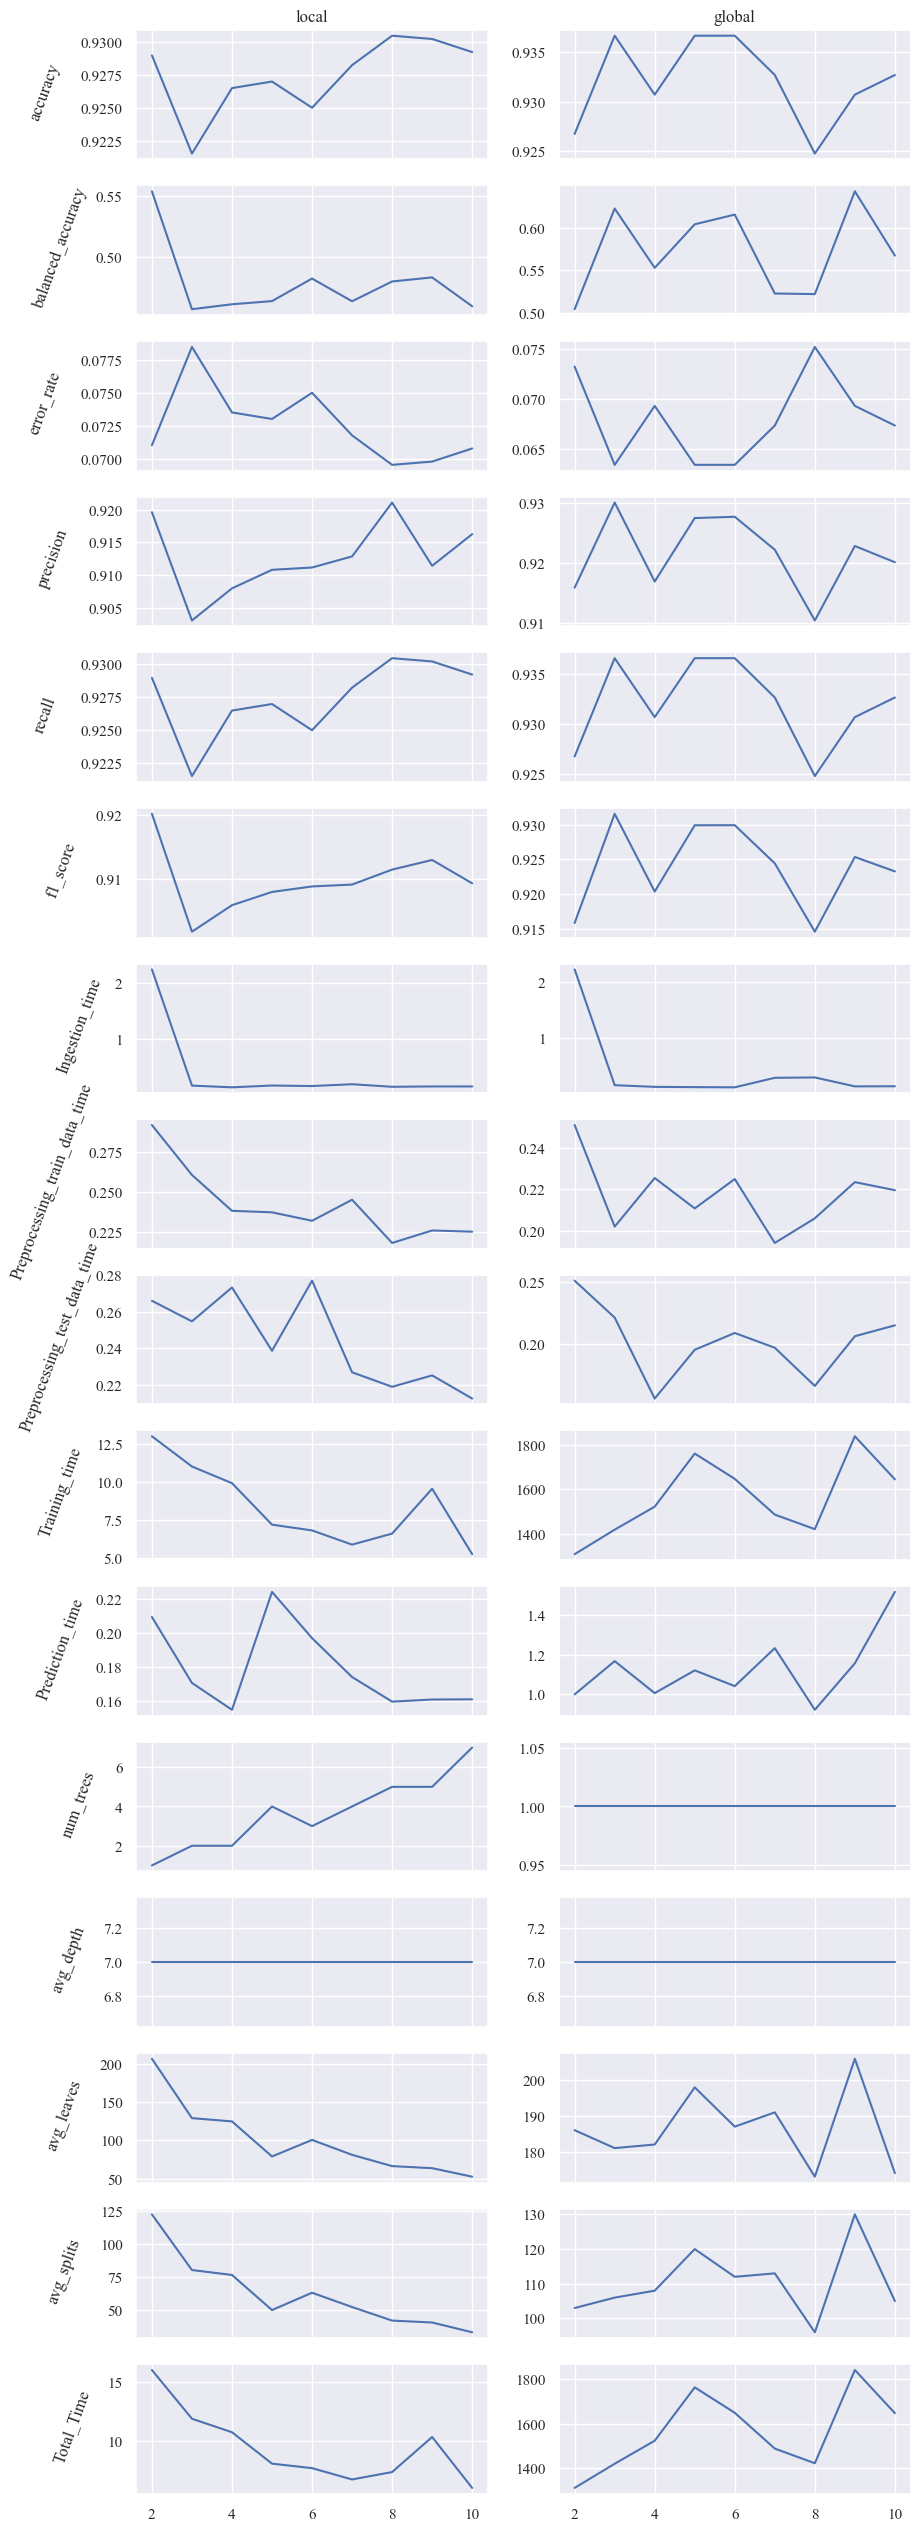

In [42]:
fig, ax = plt.subplots(nrows=len(df_list[0].columns), ncols=len(df_list), sharex=True, figsize=(len(df_list) * 5, len(df_list[0].columns) * 2))

for j, df in enumerate(df_list):
    for i, col in enumerate(df.columns):
        vals = df[col]
        ax[i, j].plot(vals.index, vals.values)
        if j == 0:
            ax[i, j].set_ylabel(col, rotation=70, labelpad=20)
        if i == 0:
            ax[i, j].set_title(f"{df_names[j]}", fontsize=12)

plt.savefig(f'metrics.png', dpi=300, bbox_inches='tight')

## Accuracy vs Partition number : Performance


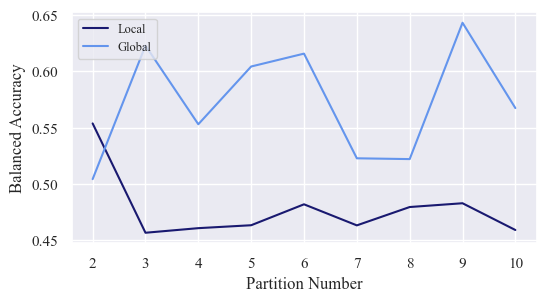

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))


ax.plot(local_avg['balanced_accuracy'], color='midnightblue')
ax.plot(global_avg['balanced_accuracy'], color='cornflowerblue')       
ax.set_ylabel(f"Balanced Accuracy")
ax.set_xlabel(f"Partition Number")
ax.legend(['Local', 'Global'], loc='upper left', fontsize=9)

plt.savefig(f'balancedAccuracyVSpartition.png', dpi=1200, bbox_inches='tight')

## Runtime vs Partition number : Speed

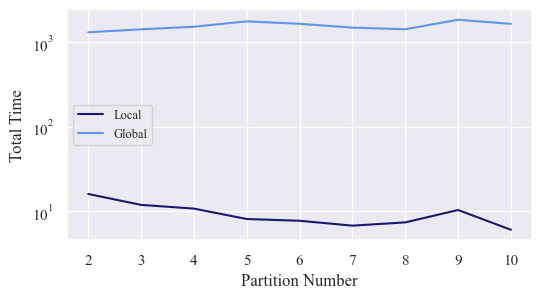

In [44]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))


ax.plot(local_avg['Total_Time'], color='midnightblue')
ax.plot(global_avg['Total_Time'], color='cornflowerblue')

ax.set_ylabel(f"Total Time")
ax.set_xlabel(f"Partition Number")
ax.legend(['Local', 'Global'], loc='center left', fontsize=9)
ax.set_yscale('log')

plt.savefig(f'runtimeVSpartition.png', dpi=1200, bbox_inches='tight')

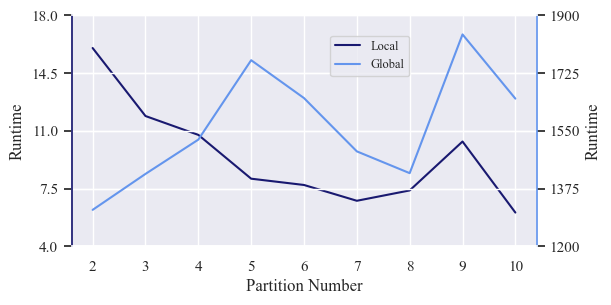

In [45]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax2 = ax1.twinx()
n_breaks = 5

ax1.plot(local_avg['Total_Time'], color='midnightblue')
ax1.set_ylim(4,18)
ax1.set_yticks(np.linspace(4, 18, n_breaks))
ax1.set_ylabel("Runtime")
#ax1.tick_params(axis='y', labelcolor='midnightblue')

ax2.plot(global_avg['Total_Time'], color='cornflowerblue')
ax2.set_ylim(1200, 1900)
ax2.set_ylabel("Runtime")
ax2.set_yticks(np.linspace(1200, 1900, n_breaks))
#ax2.tick_params(axis='y', labelcolor='cornflowerblue')

ax2.spines['left'].set_color('midnightblue')
ax2.spines['right'].set_color('cornflowerblue')

ax1.set_xlabel("Partition Number")

fig.legend(['Local', 'Global'], loc=[0.54, 0.75], fontsize=9)

plt.savefig(f'runtimeVSpartition-twinAx.png', dpi=1200, bbox_inches='tight')

## Accuracy vs Runtime : trade-off

Consider adding a line of best fit. 

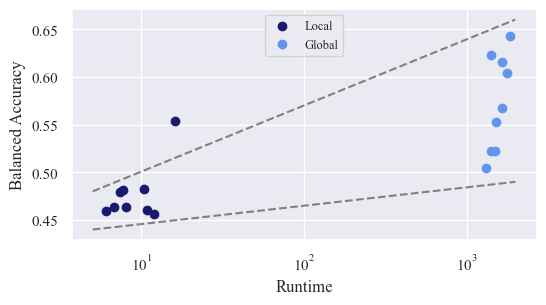

In [46]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

ax.scatter(local_avg['Total_Time'], local_avg['balanced_accuracy'], color='midnightblue')
ax.scatter(global_avg['Total_Time'], global_avg['balanced_accuracy'], color='cornflowerblue')
ax.plot(np.logspace(0.7, 3.3, 100), np.linspace(0.48, 0.66, 100), color='grey', linestyle='--')
ax.plot(np.logspace(0.7, 3.3, 100), np.linspace(0.44, 0.49, 100), color='grey', linestyle='--')
ax.set_ylabel(f"Balanced Accuracy")
ax.set_xlabel(f"Runtime")
ax.set_xscale('log')
ax.legend(['Local', 'Global'], loc='upper center', fontsize=9)

plt.savefig(f'balancedAccuracyVSruntime.png', dpi=1200, bbox_inches='tight')

## Speed-up - NEEDS WORK

Need to loop over changing processor number for this. 

In [ ]:
local_serial_speed = 20 #seconds
global_serial_speed = 1200 #seconds
local_avg['Speed_up'] = local_serial_speed / local_avg['Total_Time'] 
global_avg['Speed_up'] = global_serial_speed / global_avg['Total_Time']

Text(0.5, 1.0, 'Global Speedup')

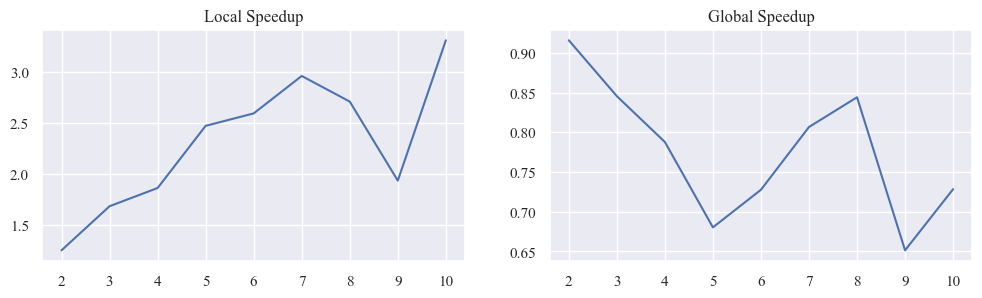

In [62]:
fig, ax = plt.subplots(1,2, figsize=(12, 3))
ax[0].plot(local_avg['Speed_up'])
ax[0].set_title('Local Speedup')
ax[1].plot(global_avg['Speed_up'])
ax[1].set_title('Global Speedup')